In [18]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from typing import List, Tuple

import pathlib
import datetime
import time
AUTOTUNE = tf.data.AUTOTUNE

from tf_augmentation import ds_augment
from get_model import *
from utils import *

In [2]:
data_dir = pathlib.Path("C:/Users/AORUS/dataset")

In [3]:
REPEAT_TIMES = 20
SHUFFLE_BUFFER = 1000
BATCH_SIZE = 64
IMG_SIZE = 96
EPOCHS = 10

In [4]:
train_ds : tf.data.Dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
)
val_ds : tf.data.Dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
)
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)
print(f"num: {num_classes}")
train_ds_ = train_ds.cache(str(data_dir / "train_ds")).unbatch().repeat(REPEAT_TIMES).shuffle(SHUFFLE_BUFFER, reshuffle_each_iteration=True)
val_ds_ = val_ds.cache(str(data_dir / "val_ds")).unbatch().repeat(max(1, REPEAT_TIMES // 4)).shuffle(SHUFFLE_BUFFER, reshuffle_each_iteration=True)

train_ds = ds_augment(train_ds_).batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_ds = ds_augment(val_ds_).batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

Found 2369 files belonging to 15 classes.
Found 2369 files belonging to 15 classes.
['apple', 'banana', 'bus', 'car', 'cat', 'cow', 'dog', 'durian', 'grape', 'horse', 'orange', 'pig', 'plane', 'ship', 'train']
num: 15


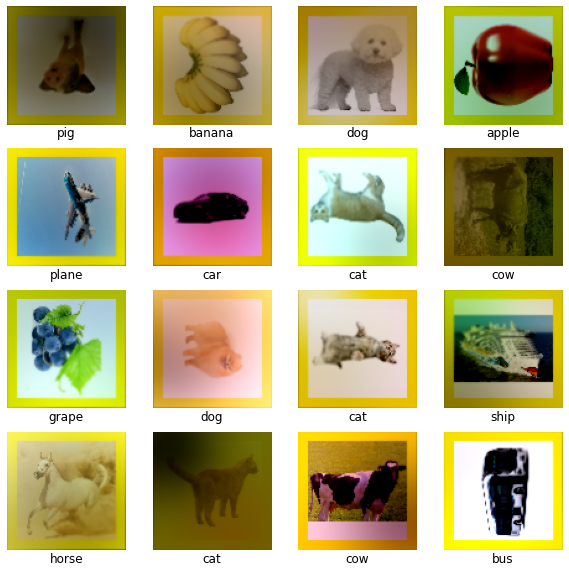

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i] / 255)
        plt.title(class_names[labels[i]], y=-0.15)
        plt.axis("off")

In [6]:
export_path = f"D:/SmartCar/TFLite_Smartcar/saved_models/{int(time.time())}"
print(export_path)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=export_path,
    save_best_only=True,
    monitor="val_loss",
    mode='min',
)

historyViewer = HistoryViewer()

D:/SmartCar/TFLite_Smartcar/saved_models/1644299422


In [7]:
base_model, model = get_EfficientNetV2B1(IMG_SIZE, num_classes, trainable=False)
model.summary()

Model: "efficientnetv2-b1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-b1 (Function  (None, 3, 3, 1280)       6931124   
 al)                                                             
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                                 
 top_dropout (Dropout)       (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 15)                19215     
                                                                 
Total params: 6,950,339
Trainable params: 19,215


In [23]:
base_model.trainable = True
model.summary()

Model: "efficientnetv2-b1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-b1 (Function  (None, 3, 3, 1280)       6931124   
 al)                                                             
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                                 
 top_dropout (Dropout)       (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 15)                19215     
                                                                 
Total params: 6,950,339
Trainable params: 6,879,2

Epoch 11/20
741/741 [==============================] - 297s 381ms/step - loss: 1.0014 - accuracy: 0.6715 - val_loss: 0.6188 - val_accuracy: 0.7945
Epoch 12/20
741/741 [==============================] - 281s 378ms/step - loss: 0.5464 - accuracy: 0.8137 - val_loss: 0.4204 - val_accuracy: 0.8596
Epoch 13/20
741/741 [==============================] - 327s 441ms/step - loss: 0.4059 - accuracy: 0.8597 - val_loss: 0.3165 - val_accuracy: 0.8938
Epoch 14/20
741/741 [==============================] - 262s 353ms/step - loss: 0.3261 - accuracy: 0.8881 - val_loss: 0.2459 - val_accuracy: 0.9179
Epoch 15/20
741/741 [==============================] - 260s 350ms/step - loss: 0.2710 - accuracy: 0.9059 - val_loss: 0.1924 - val_accuracy: 0.9383
Epoch 16/20
741/741 [==============================] - 302s 407ms/step - loss: 0.2277 - accuracy: 0.9222 - val_loss: 0.1629 - val_accuracy: 0.9475
Epoch 17/20
741/741 [==============================] - 320s 431ms/step - loss: 0.1902 - accuracy: 0.9355 - val_loss: 0

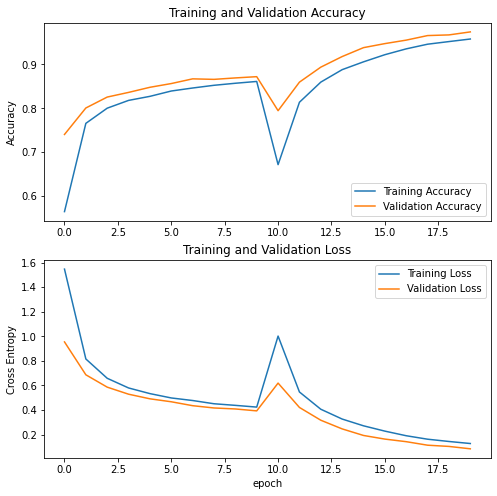

In [24]:
learning_rate = 0.0001

model.compile(
    # optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate / 10),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    initial_epoch=10,
    epochs=20,
    validation_data=val_ds,
    callbacks=[model_checkpoint_callback],
)
historyViewer.update(history)
historyViewer.show()